In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
from mpl_toolkits.mplot3d import Axes3D

In [2]:
data = pd.read_csv('data.txt', sep='\t')
data.head().T

,0,1,2,3,4
k1,0.942380,1.980494,0.374160,7.859079,1.779376
k2,0.060563,0.274382,0.001494,0.831978,0.005596
k3,0.678302,0.916775,0.085138,2.449864,0.883293
k4,-0.161531,0.624425,-1.504990,0.875862,0.527853
k5,0.202055,0.089377,0.235739,0.059439,0.135491
k6,0.165019,0.220648,0.508929,0.030030,0.886686
k7,0.399033,0.000000,0.888889,0.011111,0.489796
k8,0.799019,0.933519,0.779049,0.942010,0.887341
k9,5.426569,14.041958,5.017007,16.244444,10.558673
k10,0.209235,0.215083,0.096737,0.876663,0.313389


### Research main descriptive statistics:

In [3]:
data.aggregate([np.min, np.max, np.mean, np.median, np.std]).T

,amin,amax,mean,median,std
k1,0.248322,10.293766,1.921478,1.470692,1.396230
k2,0.000000,3.243494,0.208770,0.054770,0.403334
k3,0.009827,5.986989,0.783700,0.535862,0.777255
k4,-3.529993,0.931436,0.050654,0.148021,0.568099
k5,0.018089,1.083702,0.344513,0.317965,0.194151
k6,0.000000,1.000000,0.237445,0.186528,0.209898
k7,0.000000,1.000000,0.174289,0.076124,0.222673
k8,0.053766,0.981911,0.657750,0.682670,0.191892
k9,0.059320,54.282963,6.600649,4.771666,6.275273
k10,0.040014,5.105631,0.808938,0.618753,0.693219


### Graphical analysis:

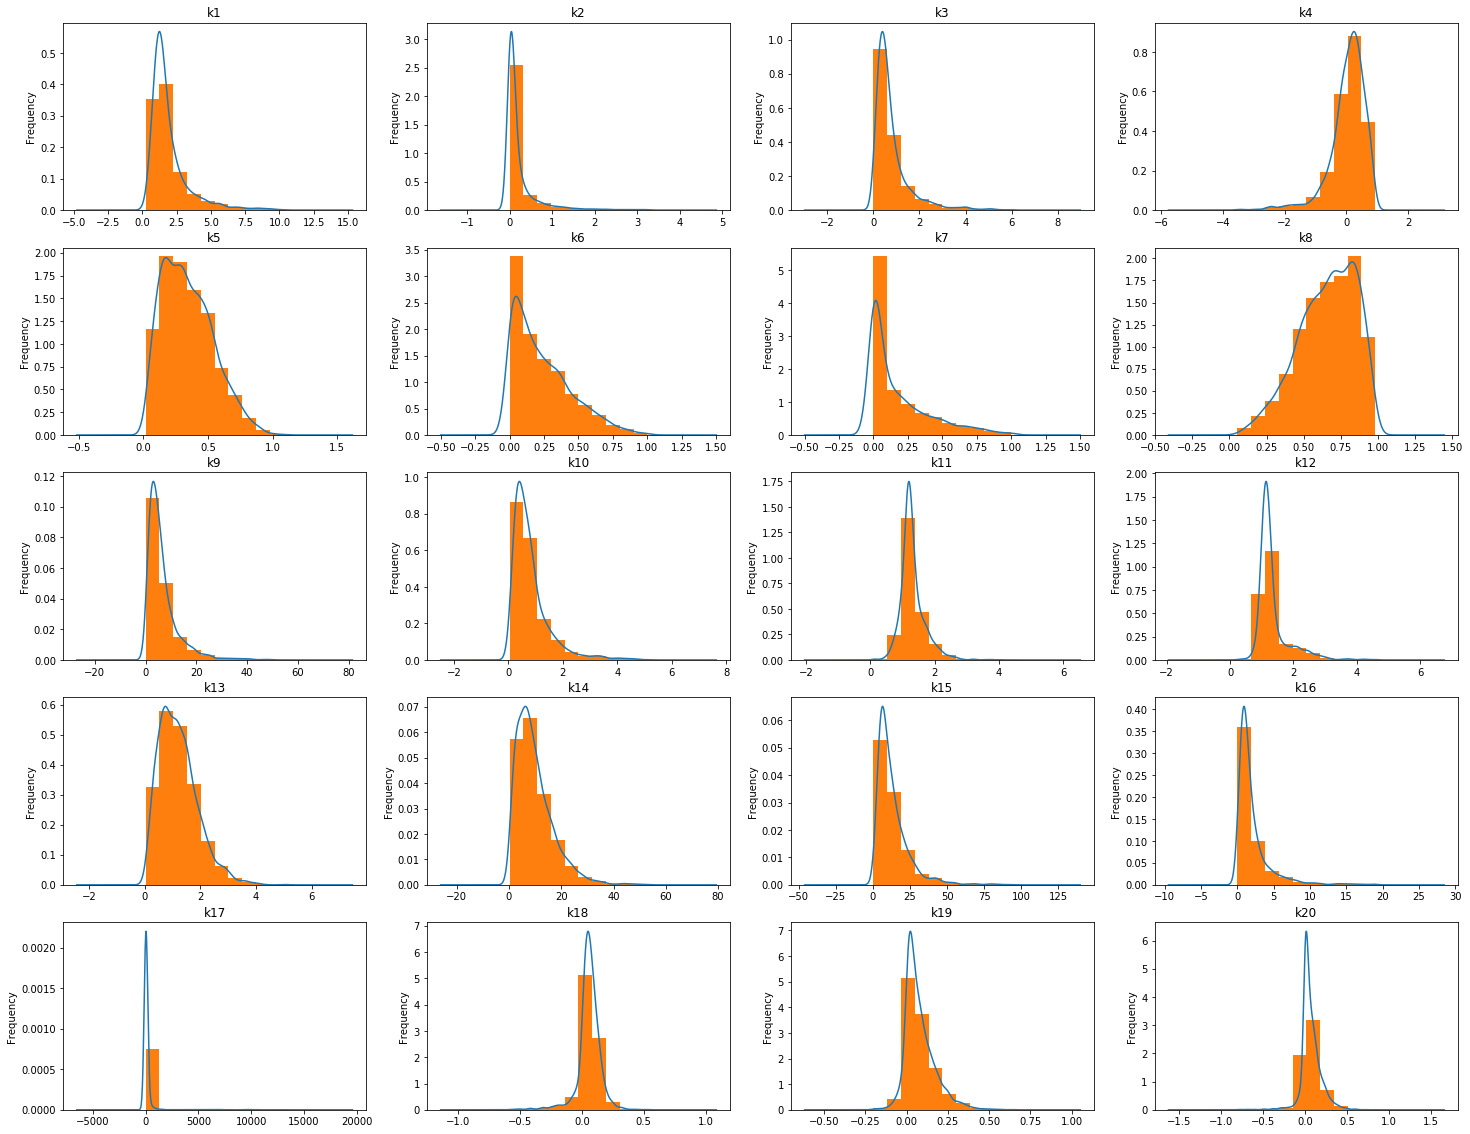

In [4]:
plt.figure(figsize=(25, 20))
for index, feature in enumerate(data):
    plt.subplot(5, 4, index + 1)
    data[feature].plot.kde(title=feature)  # kernel density estimation
    data[feature].plot.hist(density=True)

plt.show()

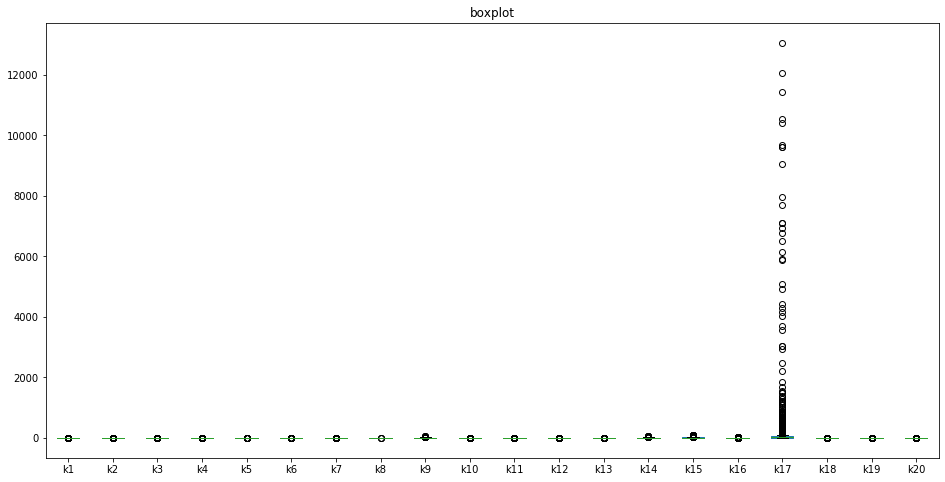

In [5]:
data.plot.box(title='boxplot', figsize=(16, 8))
plt.show()

### Six sigma rule:

In [6]:
for k in data:
    temp = (np.abs(data[k] - data[k].mean())) > 6 * data[k].std()
    print('percentage of outliers of {:>3}: {:06.3f}%'.format(k, np.sum(temp) / len(temp) * 100))

percentage of outliers of  k1: 00.000%
percentage of outliers of  k2: 00.539%
percentage of outliers of  k3: 00.116%
percentage of outliers of  k4: 00.077%
percentage of outliers of  k5: 00.000%
percentage of outliers of  k6: 00.000%
percentage of outliers of  k7: 00.000%
percentage of outliers of  k8: 00.000%
percentage of outliers of  k9: 00.193%
percentage of outliers of k10: 00.039%
percentage of outliers of k11: 00.154%
percentage of outliers of k12: 00.193%
percentage of outliers of k13: 00.000%
percentage of outliers of k14: 00.039%
percentage of outliers of k15: 00.270%
percentage of outliers of k16: 00.424%
percentage of outliers of k17: 00.771%
percentage of outliers of k18: 00.231%
percentage of outliers of k19: 00.039%
percentage of outliers of k20: 00.193%


### Searching multiplier for 5-8% outliers (outliers is NaN), censorship and normalization data:

In [7]:
mask = np.ones(data.shape[0], dtype=bool)

for k in data:
    coef = data[k].max() / data[k].std()
    temp = (np.abs(data[k] - data[k].mean())) > coef * data[k].std()
    delta = coef / 2
    count = 0
    
    while np.abs(np.sum(temp) / len(temp) - 0.065) > 1e-3 and count < 20:
        coef += -delta if np.sum(temp) / len(temp) < 0.065 else delta
        temp = (np.abs(data[k] - data[k].mean())) > coef * data[k].std()
        delta, count = delta / 2, count + 1
    
    mask = np.logical_and(mask, np.abs(data[k] - data[k].mean()) < coef * data[k].std())
    print('percentage of outliers of {:>3} with multiplier {:.2f}: {:06.3f}%'
          .format(k, coef, np.sum(temp) / len(temp) * 100),)
    
data = data[mask]
for k in data:
    data[k] = (data[k] - data[k].min()) / (data[k].max() - data[k].min())  # normalization

percentage of outliers of  k1 with multiplier 1.73: 06.551%
percentage of outliers of  k2 with multiplier 1.51: 06.513%
percentage of outliers of  k3 with multiplier 1.72: 06.590%
percentage of outliers of  k4 with multiplier 1.51: 06.551%
percentage of outliers of  k5 with multiplier 1.68: 06.551%
percentage of outliers of  k6 with multiplier 1.81: 06.513%
percentage of outliers of  k7 with multiplier 2.03: 06.513%
percentage of outliers of  k8 with multiplier 1.69: 06.513%
percentage of outliers of  k9 with multiplier 1.69: 06.513%
percentage of outliers of k10 with multiplier 1.61: 06.551%
percentage of outliers of k11 with multiplier 1.83: 06.590%
percentage of outliers of k12 with multiplier 1.94: 06.474%
percentage of outliers of k13 with multiplier 1.64: 06.513%
percentage of outliers of k14 with multiplier 1.74: 06.435%
percentage of outliers of k15 with multiplier 1.54: 06.590%
percentage of outliers of k16 with multiplier 1.61: 06.435%
percentage of outliers of k17 with multi

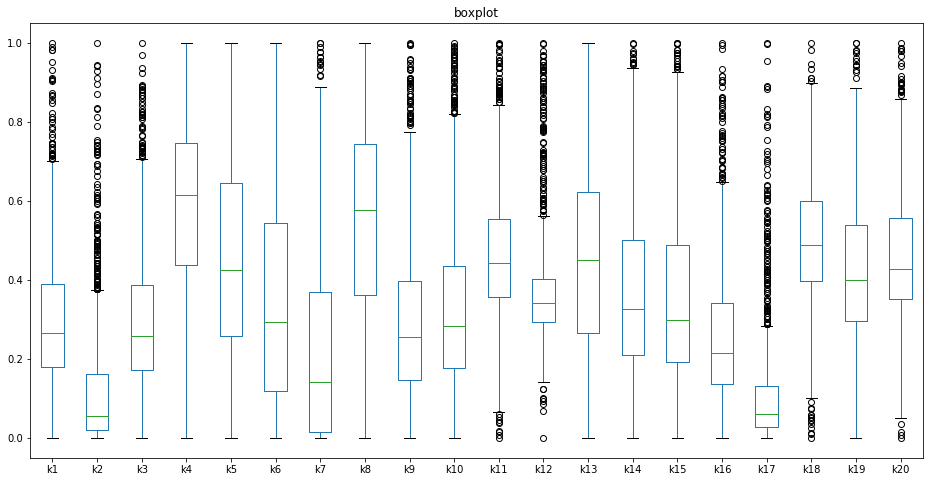

In [8]:
data.plot.box(title='boxplot', figsize=(16, 8))
plt.show()

### Close conections components:

In [9]:
corr = data.corr()
print(np.round(corr, 3), end='\n\n')
close_components = corr[np.abs(corr - np.identity(len(corr))) > 0.85].idxmax().dropna()
print('Most close components is:')
print(*close_components[::2].values)
print(*close_components[1::2].values)

        k1     k2     k3     k4     k5     k6     k7     k8     k9    k10  \
k1   1.000  0.516  0.752  0.621 -0.460 -0.074 -0.186  0.451  0.412  0.071   
k2   0.516  1.000  0.604  0.298 -0.254 -0.150 -0.261  0.251  0.238 -0.013   
k3   0.752  0.604  1.000  0.412 -0.285 -0.077 -0.172  0.281  0.269  0.080   
k4   0.621  0.298  0.412  1.000 -0.663 -0.036 -0.157  0.660  0.318  0.171   
k5  -0.460 -0.254 -0.285 -0.663  1.000  0.036  0.119 -0.998 -0.633  0.536   
k6  -0.074 -0.150 -0.077 -0.036  0.036  1.000  0.412 -0.024 -0.040 -0.010   
k7  -0.186 -0.261 -0.172 -0.157  0.119  0.412  1.000 -0.112 -0.147  0.014   
k8   0.451  0.251  0.281  0.660 -0.998 -0.024 -0.112  1.000  0.630 -0.541   
k9   0.412  0.238  0.269  0.318 -0.633 -0.040 -0.147  0.630  1.000 -0.471   
k10  0.071 -0.013  0.080  0.171  0.536 -0.010  0.014 -0.541 -0.471  1.000   
k11 -0.011  0.110  0.060  0.004  0.017 -0.102 -0.159 -0.020  0.030  0.009   
k12  0.015  0.090  0.072  0.012  0.028 -0.082 -0.118 -0.032 -0.014  0.038   

**Exclude correlated features**

In [10]:
low_corr_data = data.drop(columns = close_components[::2].values)
low_corr_data.head().T

,6,8,9,13,15
k1,0.098597,0.451991,0.197415,0.245320,0.227536
k2,0.009823,0.137657,0.077330,0.012315,0.049036
k3,0.086797,0.368075,0.203479,0.260206,0.153001
k4,0.382400,0.865250,0.568142,0.668490,0.348037
k5,0.708862,0.226455,0.468313,0.273354,0.350089
k6,0.695320,0.037999,0.094229,0.754555,0.489312
k7,0.143959,0.124823,0.065770,0.658096,0.338944
k9,0.098462,0.316171,0.233824,0.337768,0.635181
k10,0.320831,0.356856,0.277969,0.179780,0.076868
k11,0.421165,0.275497,0.205160,0.285318,0.370819


### Bartlett's sphericity criterion, statistics Kaiser - Meyer - Olkin:

In [11]:
new_length = len(low_corr_data) - np.max([low_corr_data[k].isna().sum() for k in low_corr_data])
censor_data = np.array([low_corr_data[k].dropna().to_numpy()[:new_length] for k in low_corr_data])
censor_data = pd.DataFrame(censor_data.T, columns=low_corr_data.columns)
print('Chi-square statistic: %.2f; p-value: %.2f' % calculate_bartlett_sphericity(censor_data))
print('Statistics Kaiser - Meyer - Olkin: %.3f' % calculate_kmo(censor_data)[1])

Chi-square statistic: 11501.04; p-value: 0.00
Statistics Kaiser - Meyer - Olkin: 0.590


*Factor analysis is applicable*

### Factor analysis:

In [12]:
eig_vals, eig_vecs = np.linalg.eig(low_corr_data.corr())
eig_pairs = np.array(sorted(list(zip(eig_vals, eig_vecs)), key=lambda x: -x[0]))
eig_vals = eig_pairs[:, 0]
normalized = eig_vals / np.sum(eig_vals) * 100
pd.DataFrame(np.array([eig_vals, normalized, np.cumsum(normalized)]).T,
             columns=['eig_value', 'percent_var', 'cum_percent_var'])

,eig_value,percent_var,cum_percent_var
0,4.17516,23.1953,23.1953
1,2.598,14.4333,37.6287
2,2.07415,11.5231,49.1517
3,1.66646,9.25812,58.4099
4,1.40591,7.81064,66.2205
5,1.14974,6.38743,72.6079
6,0.966088,5.36716,77.9751
7,0.811897,4.51054,82.4856
8,0.665571,3.69762,86.1832
9,0.57483,3.1935,89.3767


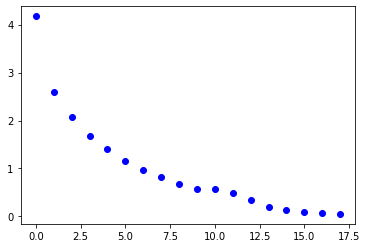

In [13]:
plt.plot(eig_vals, 'bo')
plt.show()

### Principal component analysis:

In [14]:
transform_matrix = np.array([*eig_pairs[:, 1][np.cumsum(normalized) < 60]])
pca_data = pd.DataFrame(censor_data.dot(transform_matrix.T))
censor_data.shape, pca_data.shape

((1018, 18), (1018, 4))

### Cluster analysis:

In [15]:
from sklearn.cluster import KMeans

count = 4
model = KMeans(n_clusters=count)
model.fit(pca_data)
pca_data['clusters'] = model.predict(pca_data)

print('Size of clusters:')
print(pd.Series(pca_data.clusters).value_counts())
print('Size of clusters in percents:')
print(np.round(pd.Series(pca_data.clusters).value_counts() / pca_data.shape[0] * 100, 2))
pd.DataFrame(model.cluster_centers_)

Size of clusters:
2    342
0    250
3    223
1    203
Name: clusters, dtype: int64
Size of clusters in percents:
2    33.60
0    24.56
3    21.91
1    19.94
Name: clusters, dtype: float64


,0,1,2,3
0,0.975472,-0.124650,-0.193935,-0.157532
1,0.632757,-0.377757,-0.490943,0.315789
2,0.581350,-0.103857,-0.223133,0.099765
3,0.898807,0.009979,-0.428864,0.158969


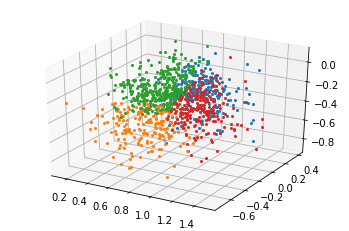

In [16]:
import mpl_toolkits.mplot3d

for i in range(4):
    temp = pca_data[pca_data['clusters'] == i]
    plt.gca(projection='3d')
    plt.plot(temp[0], temp[1], temp[2], 'o', markersize=2)

### Discriminant analysis:

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

x_train, x_validate, y_train, y_validate = train_test_split(
    pca_data.drop(['clusters'], axis=1), pca_data.clusters, train_size=0.7)

lda = LinearDiscriminantAnalysis()
lda.fit(x_train, y_train)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [18]:
pd.crosstab(y_train, lda.predict(x_train))

col_0,0,1,2,3
clusters,,,,
0,154,0,8,3
1,0,125,7,1
2,1,0,246,0
3,3,0,13,151


In [19]:
cross_validate = pd.crosstab(y_validate, lda.predict(x_validate))
cross_validate

col_0,0,1,2,3
clusters,,,,
0,78,0,4,3
1,1,60,4,5
2,0,0,95,0
3,3,0,3,50


In [20]:
cross_validate / np.sum(cross_validate, axis=1)

col_0,0,1,2,3
clusters,,,,
0,0.917647,0.000000,0.042105,0.053571
1,0.011765,0.857143,0.042105,0.089286
2,0.000000,0.000000,1.000000,0.000000
3,0.035294,0.000000,0.031579,0.892857


In [21]:
cross_validate = pd.crosstab(y_validate, lda.predict(x_validate), normalize=True)

print('Total error %.5f' % np.sum((cross_validate - np.diag(np.diag(cross_validate))).to_numpy()))

pd.DataFrame(np.array([
    np.diag(cross_validate),
    np.sum(cross_validate - np.diag(np.diag(cross_validate)), axis=1)
]).T, columns=['Estimation of cluster probability', 'Estimation of error'])

Total error 0.07516


,Estimation of cluster probability,Estimation of error
0,0.254902,0.022876
1,0.196078,0.032680
2,0.310458,0.000000
3,0.163399,0.019608


Coefficitents of analyzing functions:

In [22]:
pd.DataFrame(lda.coef_).T

,0,1,2,3
0,10.700070,-4.550157,-7.929466,4.779865
1,-1.810758,-11.443976,2.060148,7.856092
2,7.485621,-8.003901,4.076618,-7.051098
3,-10.143655,8.623491,0.331433,2.664161


### Classification based on the logit model multiple choise:

In [23]:
from sklearn.linear_model import LogisticRegression

lreg = LogisticRegression()
lreg.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [24]:
pd.crosstab(y_train, lreg.predict(x_train))

col_0,0,1,2,3
clusters,,,,
0,162,0,3,0
1,0,122,7,4
2,6,2,239,0
3,5,5,11,146


In [25]:
cross_validate = pd.crosstab(y_validate, lreg.predict(x_validate))
cross_validate

col_0,0,1,2,3
clusters,,,,
0,82,0,2,1
1,1,56,6,7
2,0,1,94,0
3,6,0,3,47


In [26]:
cross_validate / np.sum(cross_validate, axis=1)

col_0,0,1,2,3
clusters,,,,
0,0.964706,0.000000,0.021053,0.017857
1,0.011765,0.800000,0.063158,0.125000
2,0.000000,0.014286,0.989474,0.000000
3,0.070588,0.000000,0.031579,0.839286


In [27]:
cross_validate = pd.crosstab(y_validate, lreg.predict(x_validate), normalize=True)

print('Total error %.5f' % np.sum((cross_validate - np.diag(np.diag(cross_validate))).to_numpy()))

pd.DataFrame(np.array([
    np.diag(cross_validate),
    np.sum(cross_validate - np.diag(np.diag(cross_validate)), axis=1)
]).T, columns=['Estimation of cluster probability', 'Estimation of error'])

Total error 0.08824


,Estimation of cluster probability,Estimation of error
0,0.267974,0.009804
1,0.183007,0.045752
2,0.307190,0.003268
3,0.153595,0.029412


In [28]:
pd.DataFrame(lreg.coef_).T

,0,1,2,3
0,4.748992,-2.023946,-6.398333,2.791680
1,-1.399270,-6.494163,2.263469,5.796475
2,4.265233,-3.784930,3.941197,-3.942140
3,-6.619891,3.965222,0.263331,2.381723
